In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import hddm
import kabuki
import arviz as az
import seaborn as sns
import numpy as np
import warnings
import sys 
import os  
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [52]:
version=1 # 两种模型
id=1 #实验编号
#### don't modify
prefix='/home/jovyan'
user=f'weight/v{version}'
# sample_num=10000
# burn_num=sample_num//2
# chains_num=2


## exp

### data

##### load

In [3]:
data = hddm.load_csv(f'{prefix}/data/exp{id}.csv')
data = hddm.utils.flip_errors(data)
data

,subj_idx,response,rt,dif,Info,Third
0,18,1,1.77510,219,EV,low
1,18,0,-3.42390,11,EV,low
2,18,1,1.78910,8,EV,low
3,18,1,2.87890,5,EV,low
4,18,0,-1.51660,2,EV,low
...,...,...,...,...,...,...
10572,66,1,1.13340,90,MV,mid
10573,66,1,1.11700,89,MV,high
10574,66,1,1.71680,116,MV,mid
10575,66,1,0.76667,135,MV,high


##### analysis

In [4]:
data.describe()

,subj_idx,response,rt,dif
count,10577.000000,10577.000000,10577.000000,10577.000000
mean,41.934291,0.660584,0.471421,99.724780
std,14.421272,0.473533,1.730611,81.869869
min,18.000000,0.000000,-6.028900,1.000000
25%,29.000000,0.000000,-1.077000,15.000000
50%,43.000000,1.000000,1.042900,97.000000
75%,55.000000,1.000000,1.532300,165.000000
max,66.000000,1.000000,5.992400,328.000000


<AxesSubplot: xlabel='dif', ylabel='Density'>

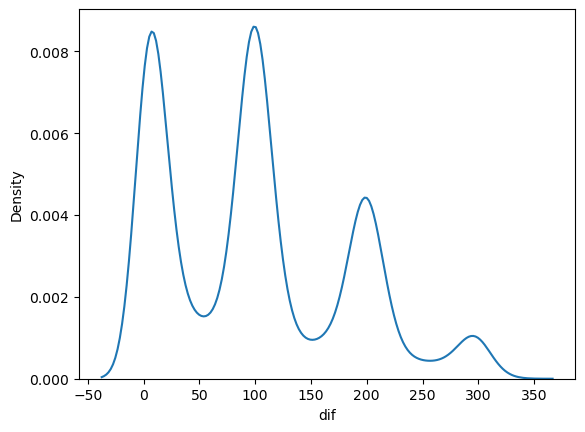

In [5]:
sns.kdeplot(data['dif'])

In [6]:
data[data['Info']=='EV'].groupby('Third')[['rt','response','dif']].mean()

,rt,response,dif
Third,,,
high,0.532357,0.701950,111.521448
low,0.439700,0.642314,95.042665
mid,0.423889,0.647422,94.282511


In [7]:
data[data['Info']=='MV'].groupby('Third')[['rt','response','dif']].mean()

,rt,response,dif
Third,,,
high,0.493389,0.685248,106.051802
low,0.491472,0.651950,95.110665
mid,0.446352,0.633277,95.964346


### load

In [53]:
rc=az.from_netcdf(f'{prefix}/{user}/exp_{id}_v{version}.nc')
pwd=os.getcwd()
os.chdir(f'{prefix}/{user}/')
model=hddm.load(f'{prefix}/{user}/exp_{id}_v{version}')
os.chdir(pwd)

### train

In [9]:
# os.makedirs(f'{prefix}/{user}',exist_ok=True)
# if version==1:
#     kwargs={
#         "models":["v~dif+C( Third,Treatment('mid'))*C(Info, Treatment('MV'))","a~C(Third, Treatment('mid'))*C(Info, Treatment('MV'))"],
#         "include":('v','a','t')
#     }
# elif version==2:
#     kwargs={
#         "models":["v~dif*C(Third, Treatment('mid'))*C(Info, Treatment('MV'))","a~C(Third, Treatment('mid'))*C(Info, Treatment('MV'))"],
#         "include":('v','a','t')
#     }
#     include=('v','a','t')
# elif version==3:
#     kwargs={"models":["v~dif+C( Third,Treatment('mid'))*C(Info, Treatment('MV'))"],
#             "include":('v','t')}
# else:
#     raise NotImplementedError
# kwargs["p_outlier"]=0.05
# kwargs["group_only_regressors"]=False
# print(f'exp:{id},version:{version},path:{prefix}/{user},sample_num:{sample_num},burn_num:{burn_num},chain_num:{chains_num},kwargs:{kwargs}')

# pwd=os.getcwd()
# os.chdir(f'{prefix}/{user}')
# model = hddm.HDDMRegressor(data,**kwargs)
# rc = model.sample(sample_num,chains=chains_num, burn=burn_num,dbname=f'{prefix}/work/exp_{id}_v{version}.db',db='pickle',return_infdata=True, sample_prior=True, loglike=True, ppc=True)
# model.save(f'{prefix}/{user}/exp_{id}_v{version}')
# az.to_netcdf(rc, f'{prefix}/{user}/exp_{id}_v{version}.nc')
# os.chdir(pwd)

### model evaluate

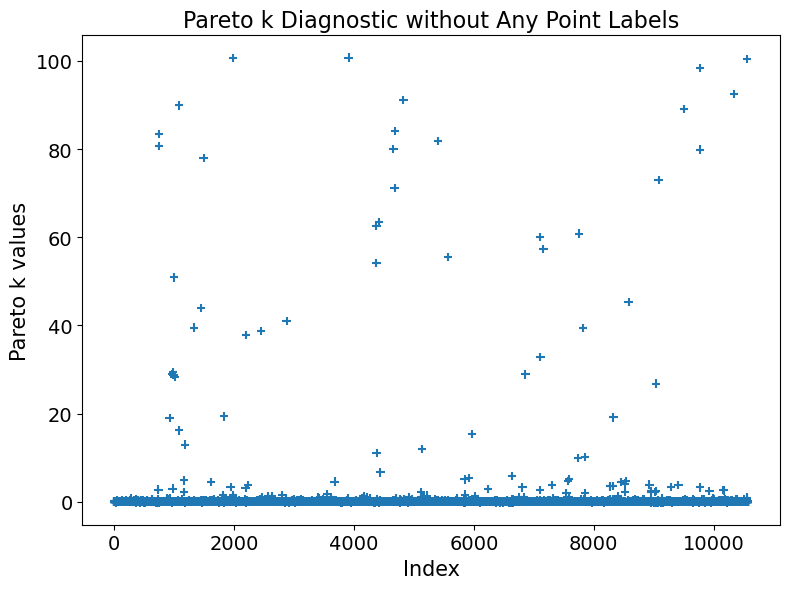

In [10]:
# khats = az.loo(rc,pointwise=True)
# az.plot_khat(khats, xlabels=True, threshold=0.8)
# khats

khats = az.loo(rc, pointwise=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_khat(khats, xlabels=False, threshold=0.8, ax=ax, show=False)

# 去除线条标签
for line in ax.get_lines():
    line.set_label("")

# 清除所有的文本标签（包括索引）
for text in ax.texts:
    text.set_visible(False)

ax.set_title("Pareto k Diagnostic without Any Point Labels", fontsize=16)
ax.set_xlabel("Index")
ax.set_ylabel("Pareto k values")
plt.tight_layout()
plt.show()


<AxesSubplot: xlabel='rt / rt\n18'>

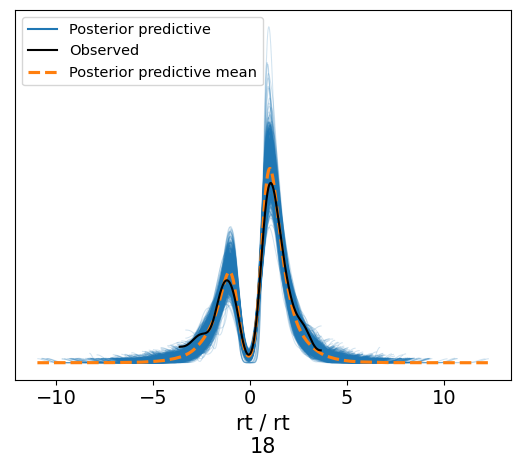

In [11]:
rc_ = rc.assign_coords(
  obs_id=rc.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

az.plot_ppc(rc_, var_names= 'rt', coords={'obs_id': [18]}, flatten=[])

In [12]:
f'dic:{model.dic:.4f}'

'dic:29054.1538'

In [13]:
summary_tmp = az.summary(rc, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]",0.0273,0.0199,10.1329,72.0384,1.1695
"v_dif:C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]",0.0002,0.0002,10.1516,58.0209,1.1443
"v_C(Info, Treatment('MV'))[T.EV]",0.0158,0.0114,14.0737,51.6415,1.1224
"v_C(Third, Treatment('mid'))[T.low]",0.0144,0.0104,14.2419,50.5830,1.1171
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_subj.35",0.0295,0.0213,14.4686,210.7738,1.1072
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_subj.33",0.0275,0.0198,16.0854,252.1401,1.1010
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_subj.52",0.0285,0.0205,16.5503,121.2335,1.0982
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_subj.55",0.0288,0.0207,15.4744,274.5831,1.0972
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_subj.23",0.0279,0.0201,15.9746,298.9873,1.0965
"v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_subj.31",0.0273,0.0197,15.9691,189.9159,1.0965


In [14]:
rc

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> prior
	> observed_data

### $P_{post}$

In [54]:
for i in params.keys():
    if '_subj' not in i:
        print(i)

t
t_std
v_Intercept
v_Intercept_std
v_C(Third, Treatment('mid'))[T.high]
v_C(Third, Treatment('mid'))[T.high]_std
v_C(Third, Treatment('mid'))[T.low]
v_C(Third, Treatment('mid'))[T.low]_std
v_C(Info, Treatment('MV'))[T.EV]
v_C(Info, Treatment('MV'))[T.EV]_std
v_C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]
v_C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]_std
v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]
v_C(Third, Treatment('mid'))[T.low]:C(Info, Treatment('MV'))[T.EV]_std
v_dif
v_dif_std
v_dif:C(Third, Treatment('mid'))[T.high]
v_dif:C(Third, Treatment('mid'))[T.high]_std
v_dif:C(Third, Treatment('mid'))[T.low]
v_dif:C(Third, Treatment('mid'))[T.low]_std
v_dif:C(Info, Treatment('MV'))[T.EV]
v_dif:C(Info, Treatment('MV'))[T.EV]_std
v_dif:C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]
v_dif:C(Third, Treatment('mid'))[T.high]:C(Info, Treatment('MV'))[T.EV]_std
v_dif:C(Third, Treatment('mid'))[T.low]:C(Info, Tr

0.0231


0.6723

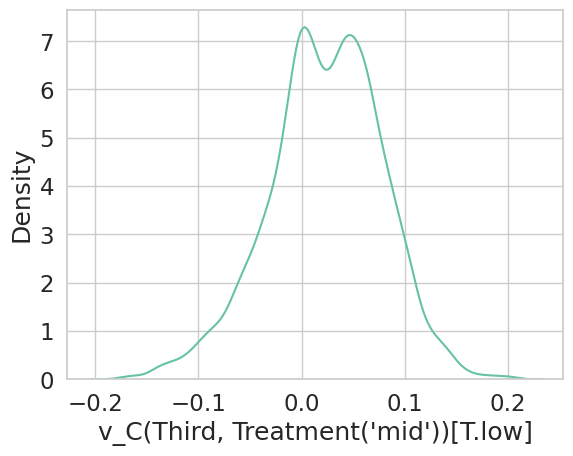

In [62]:
sns.kdeplot(params["v_C(Third, Treatment('mid'))[T.low]"])
print(f"""{params["v_C(Third, Treatment('mid'))[T.low]"].mean():.4f}""")
(params["v_C(Third, Treatment('mid'))[T.low]"]>0).mean()

0.0572


0.8281

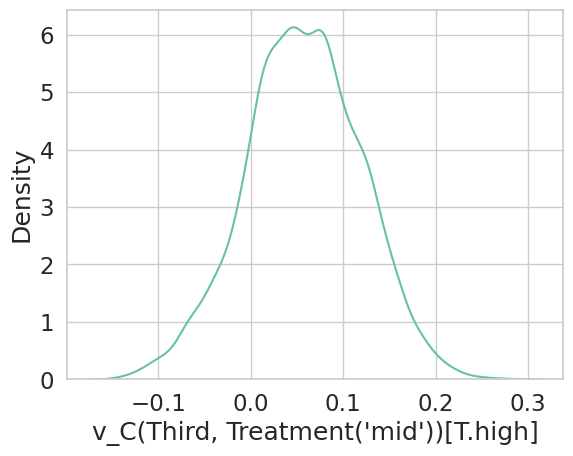

In [63]:
sns.kdeplot(params["v_C(Third, Treatment('mid'))[T.high]"])
print(f"""{params["v_C(Third, Treatment('mid'))[T.high]"].mean():.4f}""")
(params["v_C(Third, Treatment('mid'))[T.high]"]>0).mean()

-0.1237


0.9998

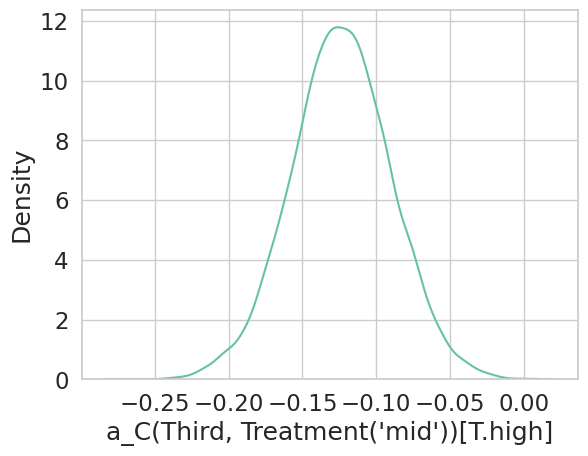

In [65]:
sns.kdeplot(params["a_C(Third, Treatment('mid'))[T.high]"])
print(f"""{params["a_C(Third, Treatment('mid'))[T.high]"].mean():.4f}""")
(params["a_C(Third, Treatment('mid'))[T.high]"]<0).mean()

0.0898


0.9982

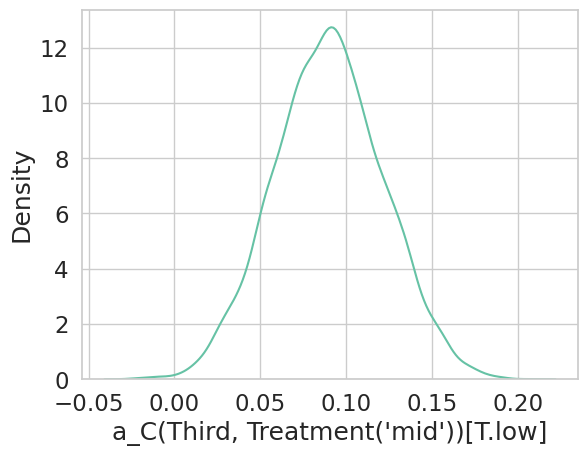

In [67]:
sns.kdeplot(params["a_C(Third, Treatment('mid'))[T.low]"])
print(f"""{params["a_C(Third, Treatment('mid'))[T.low]"].mean():.4f}""")
(params["a_C(Third, Treatment('mid'))[T.low]"]>0).mean()

In [42]:
params=model.get_traces()
p_post=(params["v_C(Third, Treatment('mid'))[T.high]"]>0).mean()
p_post

0.8281

In [42]:
params=model.get_traces()
p_post=(params["v_C(Third, Treatment('mid'))[T.high]"]>0).mean()
p_post

0.8281

### merge

##### two functions for different model

In [16]:
def get_param1(dif,prefix=''): #_subj.3
    params=model.get_traces()
    Third=['low','mid','high']
    Info=['EV','MV']
    params_list=[]
    for third in Third:
        for info in Info:
            v=params[f'v_dif{prefix}']*dif+params[f'a_Intercept{prefix}']
            a=params[f'a_Intercept{prefix}']
            if third!='mid':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
            if info!='MV':
                v+=params[f"v_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            if third!='mid' and info!='MV':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            params_list.append(pd.DataFrame({"Third":third,"Info":info,"v":v,"a":a}))
    dmm_param=pd.concat(params_list,axis=0, ignore_index=True)
    return dmm_param


In [17]:
def get_param2(dif,prefix=''):
    params_list=[]
    params=model.get_traces()
    Third=['low','mid','high']
    Info=['EV','MV']
    for third in Third:
        for info in Info:
            v=params[f'a_Intercept{prefix}']
            beta=params[f'v_dif{prefix}']
            a=params[f'a_Intercept{prefix}']
            if third!='mid':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
                beta+=params[f"v_dif:C(Third, Treatment('mid'))[T.{third}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]{prefix}"]
            if info!='MV':
                v+=params[f"v_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                beta+=params[f"v_dif:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            if third!='mid' and info!='MV':
                v+=params[f"v_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                beta+=params[f"v_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
                a+=params[f"a_C(Third, Treatment('mid'))[T.{third}]:C(Info, Treatment('MV'))[T.{info}]{prefix}"]
            V=v+beta*dif
            params_list.append(pd.DataFrame({"Third":third,"Info":info,"v":V,"a":a}))
    dmm_param=pd.concat(params_list,axis=0, ignore_index=True)
    return dmm_param

##### exec

In [18]:
# 提取 posterior predictive 检查数据
ppc_data = rc.posterior_predictive # 提取预测数据
observed_data = rc.observed_data   # 提取真实数据

# 转换为 DataFrame 格式，方便分组与可视化
ppc_df = ppc_data.to_dataframe()       # 模型预测数据
obs_df = observed_data.to_dataframe()  # 真实观测数据
aligned_df = pd.merge(obs_df, ppc_df, on='obs_id', suffixes=('_obs', '_pred'))
# 重构数据用于小提琴图
obs_values = pd.DataFrame({
    'Third': aligned_df['Third'],
    'Info':aligned_df['Info'],
    'rt': aligned_df['rt_obs'],
    'abs_rt':aligned_df['rt_pred'].abs(),
    'response':aligned_df['response_obs'],
    'Type': 'Observed'  # 真实值标签
})

pred_values = pd.DataFrame({
    'Third': aligned_df['Third'],
    'Info':aligned_df['Info'],
    'rt': aligned_df['rt_pred'],
    'abs_rt':aligned_df['rt_pred'].abs(),
    'response':aligned_df['response_pred'],
    'Type': 'Predicted'  # 预测值标签
})

# 合并数据
final_df = pd.concat([obs_values, pred_values])
final_df_cue=final_df[final_df['Info']=='EV']
final_df_no=final_df[final_df['Info']=='MV']
final_df

,Third,Info,rt,abs_rt,response,Type
obs_id,,,,,,
0,low,EV,1.775100,1.415907,1,Observed
0,low,EV,1.775100,1.382508,1,Observed
0,low,EV,1.775100,1.245588,1,Observed
0,low,EV,1.775100,1.484075,1,Observed
0,low,EV,1.775100,1.784577,1,Observed
...,...,...,...,...,...,...
10576,high,MV,-0.750029,0.750029,0,Predicted
10576,high,MV,1.679455,1.679455,1,Predicted
10576,high,MV,1.090818,1.090818,1,Predicted


In [19]:
v_dif=data['dif'].mean()
dmm_param=eval(f"get_param{version}(v_dif)")
dmm_param

,Third,Info,v,a
0,low,EV,2.461363,1.950322
1,low,EV,2.597125,2.086980
2,low,EV,2.497811,1.951450
3,low,EV,2.468791,1.913710
4,low,EV,2.561481,1.967813
...,...,...,...,...
59995,high,MV,2.279035,1.680893
59996,high,MV,2.148148,1.541138
59997,high,MV,2.143061,1.612170
59998,high,MV,2.180277,1.622859


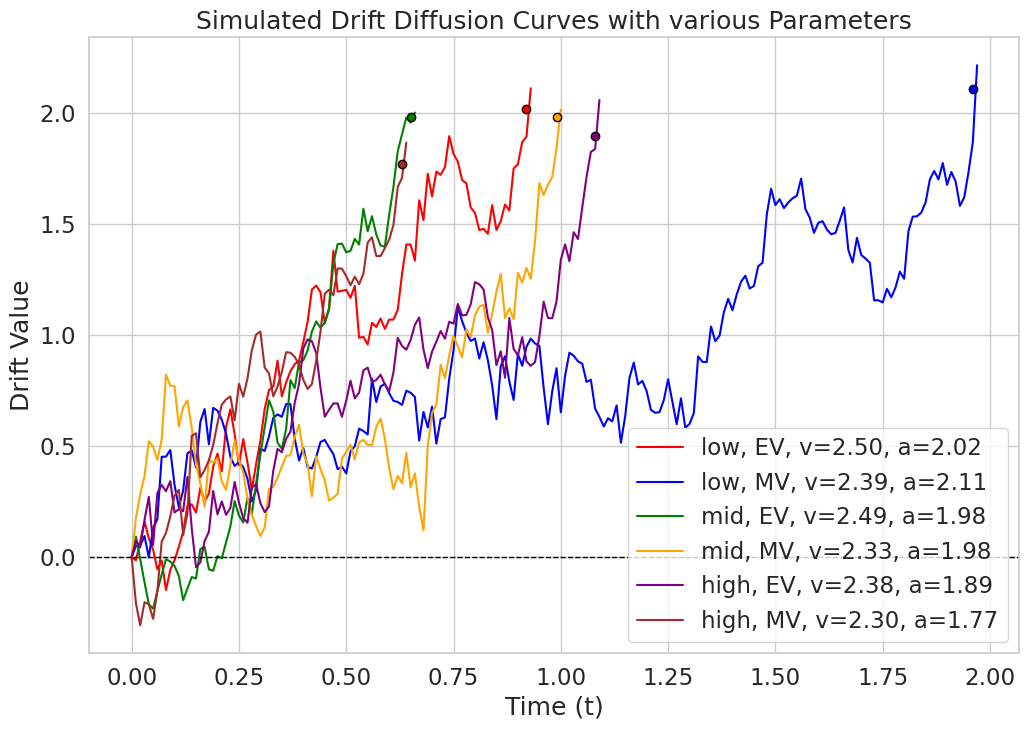

In [35]:
# 定义颜色映射
color_map = {
    ('low', 'EV'): 'red',
    ('low', 'MV'): 'blue',
    ('mid', 'EV'): 'green',
    ('mid', 'MV'): 'orange',
    ('high', 'EV'): 'purple',
    ('high', 'MV'): 'brown'
}

# 定义模拟漂移扩散过程的函数
def simulate_drift_diffusion(v, a, t_steps, dt=0.01, noise_scale=1.0):
    """
    模拟漂移扩散过程。
    :param v: 漂移率 (drift rate)
    :param a: 决策边界 (decision boundary)
    :param t_steps: 时间步长的数量
    :param dt: 每个时间步的时间长度
    :param noise_scale: 噪声强度
    :return: 漂移路径、决策时间、决策结果（+a 或 -a）
    """
    x = 0  # 初始位置（起点）
    path = [x]
    
    for t in range(t_steps):
        # 漂移：增加一个漂移项和一个噪声项
        dx = v * dt + np.random.normal(0, noise_scale * np.sqrt(dt))
        x += dx
        path.append(x)
        
        # 如果到达边界，结束
        if x >= a:
            return path, t * dt, +a  # 到达正边界
        elif x <= -a:
            return path, t * dt, -a  # 到达负边界
    
    return path, t_steps * dt, 0  # 未达到边界，返回 0 表示无决策

# 绘图
plt.figure(figsize=(12, 8))

t_steps = 1000  # 时间步长数量
dt = 0.01  # 每个时间步的长度

# 遍历每种 (Third, Info) 组合
for (third, info), color in color_map.items():
    # 筛选对应的 v 和 a
    subset = dmm_param[(dmm_param['Third'] == third) & (dmm_param['Info'] == info)]
    v = subset['v'].mean()  # 取平均漂移率
    a = subset['a'].mean()  # 取平均决策边界
    
    # 模拟漂移扩散过程
    path, decision_time, decision_result = simulate_drift_diffusion(v, a, t_steps, dt)
    
    # 时间轴
    time = np.arange(len(path)) * dt
    
    # 绘制曲线
    label = f"{third}, {info}, v={v:.2f}, a={a:.2f}"
    plt.plot(time, path, label=label, color=color)

    # 标注决策点
    if decision_result != 0:
        plt.scatter(decision_time, decision_result, color=color, edgecolor='black', zorder=5)

# 添加图例和标题
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # 初始点
plt.xlabel("Time (t)")
plt.ylabel("Drift Value")
plt.title("Simulated Drift Diffusion Curves with various Parameters")
plt.legend()
plt.grid(True)
plt.show()


### visualize

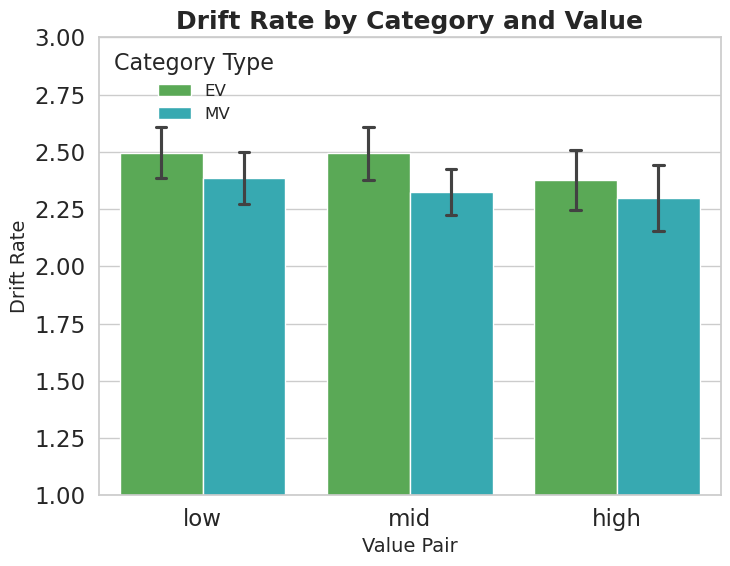

In [25]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
plt.figure(figsize=(7.5, 6))
sns.barplot(
    x='Third',
    y='v',
    hue='Info',
    data=dmm_param,
    palette={'EV': '#4DB748', 'MV': '#23BAC5'},
    ci="sd",  # 置信区间，使用标准差表示
    capsize=0.1  # 添加误差线的小帽
)
plt.title("Drift Rate by Category and Value", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Drift Rate", fontsize=14)
plt.legend(title="Category Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)
plt.tight_layout()
plt.ylim(1, 3)  # 设置 y 轴范围
plt.show()


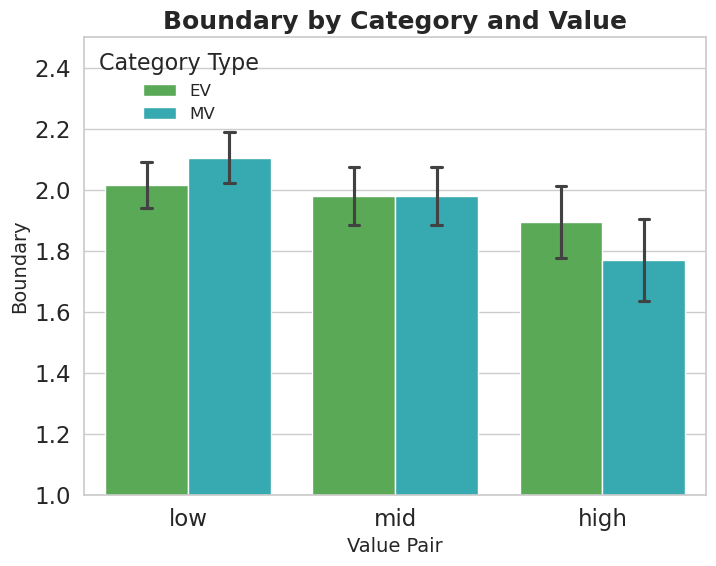

In [26]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
plt.figure(figsize=(7.5, 6)) 
sns.barplot(
    x='Third',
    y='a',
    hue='Info',
    data=dmm_param,
    palette={'EV': '#4DB748', 'MV': '#23BAC5'},
    ci="sd",  # 显示标准差
    capsize=0.1
)
plt.title("Boundary by Category and Value", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Boundary", fontsize=14)
plt.legend(title="Category Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)
plt.ylim(1, 2.5)  # 设置 y 轴范围
plt.tight_layout()
plt.show()


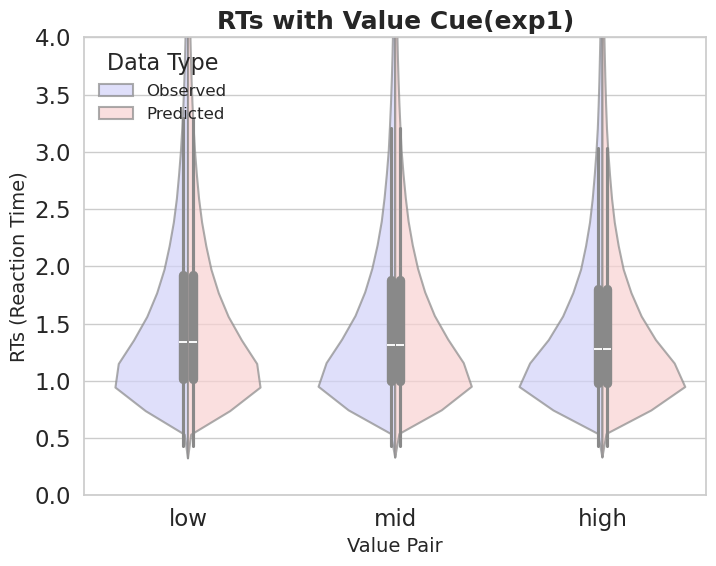

In [27]:
# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
order = ['low', 'mid', 'high']  # 按照期望顺序排列

# 绘制真实值与预测值的小提琴图
plt.figure(figsize=(7.5, 6))  # 增加图像尺寸
ax = sns.violinplot(
    x='Third',
    y='abs_rt',
    hue='Type',
    data=final_df_cue,
    palette={'Observed': '#ccccfe', 'Predicted': '#ffcccc'},  # 使用更具对比的颜色
    split=True,  # 在同一位置展示两类分布
    order=order,
    linewidth=1.5,  # 设置线条宽度
    scale='area',  # 让小提琴图的面积均匀
    alpha=0.7  # 设置透明度
)

# 添加标题与标签
plt.title("RTs with Value Cue(exp1)", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("RTs (Reaction Time)", fontsize=14)
plt.ylim(0, 4)  # 设置 y 轴范围

# 调整图例位置和样式
plt.legend(title="Data Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)

# 改善布局
plt.tight_layout()

# 显示图像
plt.show()


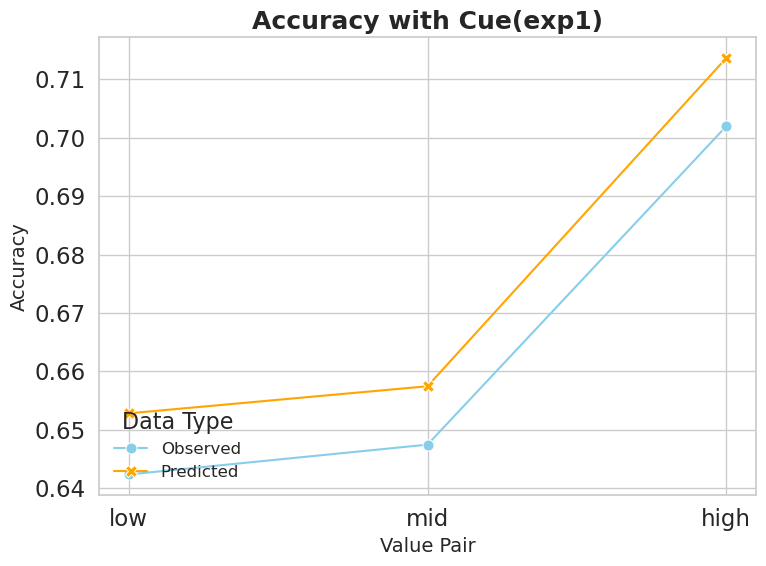

In [23]:
# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
final_df_cue['Third'] = pd.Categorical(final_df_cue['Third'], categories=['low', 'mid', 'high'], ordered=True)
order = ['low', 'mid', 'high']  # 按照期望顺序排列

# 绘制折线图
plt.figure(figsize=(8, 6))  # 增加图像尺寸
ax = sns.lineplot(
    x='Third',  # x 轴为组别
    y='response',  # y 轴为响应值
    hue='Type',  # 根据 'Type' 分别画出不同颜色的线
    data=final_df_cue,
    style='Type',  # 使 'Type' 用不同的线型区分
    markers=True,  # 显示每个点的标记
    dashes=False,  # 不使用虚线
    palette={'Observed': 'skyblue', 'Predicted': 'orange'},  # 使用对比强烈的颜色
    markersize=8,  # 标记点的大小
    ci=None  # 不显示置信区间
)

# 添加标题与标签
plt.title("Accuracy with Cue(exp1)", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# 调整图例位置和样式
plt.legend(title="Data Type", title_fontsize=16, loc="lower left", fontsize=12, frameon=False)

# 改善布局
plt.tight_layout()

# 显示图像
plt.show()


In [24]:
# 设置 Seaborn 风格
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
order = ['low', 'mid', 'high']  # 按照期望顺序排列

# 绘制真实值与预测值的小提琴图
plt.figure(figsize=(7.5, 6))  # 增加图像尺寸
ax = sns.violinplot(
    x='Third',
    y='abs_rt',
    hue='Type',
    data=final_df_no,
    palette={'Observed': '#ccccfe', 'Predicted': '#ffcccc'},  # 使用更具对比的颜色
    split=True,  # 在同一位置展示两类分布
    inner="point",  # 使用点显示内部分布，去掉四分位线
    linewidth=1.5,  # 设置线条宽度
    order=order,
    draw_centroid=True
    scale='area',  # 让小提琴图的面积均匀
    alpha=0.7  # 设置透明度
)

# 添加标题与标签
plt.title("RTs without Cue(exp1)", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("RTs (Reaction Time)", fontsize=14)
plt.ylim(0, 4)  # 设置 y 轴范围为 0 到 5

# 调整图例位置和样式
plt.legend(title="Data Type", title_fontsize=16, loc="upper left", fontsize=12, frameon=False)

# 改善布局
plt.tight_layout()

# 显示图像
plt.show()


SyntaxError: invalid syntax (1484457386.py, line 18)

In [ ]:
sns.set(style="whitegrid", palette="Set2", font_scale=1.5)
final_df_no['Third'] = pd.Categorical(final_df_no['Third'], categories=['low', 'mid', 'high'], ordered=True)
plt.figure(figsize=(8, 6))  # 增加图像尺寸
ax = sns.lineplot(
    x='Third',  # x 轴为组别
    y='response',  # y 轴为响应值
    hue='Type',  # 根据 'Type' 分别画出不同颜色的线
    data=final_df_no,
    style='Type',  # 使 'Type' 用不同的线型区分
    markers=True,  # 显示每个点的标记
    dashes=False,  # 不使用虚线
    palette={'Observed': 'skyblue', 'Predicted': 'orange'},  # 使用对比强烈的颜色
    markersize=8,  # 标记点的大小
    ci=None  # 不显示置信区间
)
plt.title("Accuracy without Cue", fontsize=18, weight='bold')
plt.xlabel("Value Pair", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.tight_layout()
plt.show()